In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,Bidirectional,Embedding,Input,Dense

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
df = pd.read_csv("drive/MyDrive/Grammar/test_dataset_csv")

In [5]:
df.head()

,incorrect,correct
0,"Bitcoin is for $7,094 this morning, which Coin...","Bitcoin goes for $7,094 this morning, accordin..."
1,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ..."
2,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
4,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...


In [6]:
df["length_incorr"] = [len(i) for i in df["incorrect"]]
df["length_corr"] = [len(i) for i in df["correct"]]

In [7]:
df.head()

,incorrect,correct,length_incorr,length_corr
0,"Bitcoin is for $7,094 this morning, which Coin...","Bitcoin goes for $7,094 this morning, accordin...",56,60
1,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ...",87,92
2,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...,334,355
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.,49,44
4,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...,54,55


In [8]:
df["length_incorr"].describe()

count    152175.000000
mean        132.274855
std         109.284164
min           2.000000
25%          62.000000
50%         106.000000
75%         172.000000
max       12705.000000
Name: length_incorr, dtype: float64

In [9]:
df["length_corr"].describe()

count    152175.000000
mean        132.002944
std          98.061967
min          12.000000
25%          62.000000
50%         106.000000
75%         173.000000
max        1160.000000
Name: length_corr, dtype: float64

In [10]:
def reduce_sentences(data_input,data_output):

  dataset_input = []
  dataset_output = []

  for i in range(len(data_input)):
    if(len(data_input[i])<=500 and len(data_output[i])<=500):
      dataset_input.append(data_input[i])
      dataset_output.append(data_output[i])

  return dataset_input,dataset_output

In [11]:
incorrect_sent,correct_sentences = reduce_sentences(df["incorrect"],df["correct"])

In [12]:
len(incorrect_sent),len(correct_sentences)

(150660, 150660)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(incorrect_sent,correct_sentences,test_size=0.1,random_state=42)

In [14]:
df_new = pd.DataFrame({
    "incorrect":X_train,
    "correct":y_train
})

In [15]:
df_test = pd.DataFrame({
    "incorrect":X_test,
    "correct":y_test
})

In [16]:
df_new.head()

,incorrect,correct
0,"All our technical staff works with ES ｃcats, s...","All our technical staff works with ESD coat, s..."
1,"28:20 And David said to Solomon his son, Be st...","28:20 And David said to Solomon his son, Be st..."
2,"Actually strap rockets to our back, though tha...","Actually strap rockets to our back, although, ..."
3,Chart of the are day: You are Better Off Than ...,Chart of the Day: Are You Better Off Than You ...
4,Olly Murs added a series of new shows to his U...,Olly Murs has added a series of new shows to h...


In [17]:
df_new.isna().sum()

incorrect    0
correct      0
dtype: int64

In [18]:
df_new.duplicated().sum()

0

In [19]:
def clean_text(sent):
  sent = re.sub(r"([?.!,])",r" \1",sent)
  sent = re.sub(f"[' ']+"," ",sent)
  sent = sent.strip()
  return sent

In [20]:
df_new["incorrect"] = df_new["incorrect"].apply(clean_text)
df_new["correct"] = df_new["correct"].apply(clean_text)

In [21]:
df_test["incorrect"] = df_test["incorrect"].apply(clean_text)
df_test["correct"] = df_test["correct"].apply(clean_text)

In [22]:
df_new.head()

,incorrect,correct
0,"All our technical staff works with ES ｃcats , ...","All our technical staff works with ESD coat , ..."
1,"28:20 And David said to Solomon his son , Be s...","28:20 And David said to Solomon his son , Be s..."
2,"Actually strap rockets to our back , though th...","Actually strap rockets to our back , although ..."
3,Chart of the are day: You are Better Off Than ...,Chart of the Day: Are You Better Off Than You ...
4,Olly Murs added a series of new shows to his U...,Olly Murs has added a series of new shows to h...


In [23]:
df["incorrect"][0]

'Bitcoin is for $7,094 this morning, which CoinDesk says.'

In [24]:
def preparing_decoder_input(sentence):
    return "<sos> " + sentence

def preparing_decoder_target(sentence):
  return sentence + " <eos>"

def preprocessing_decoder(sentence):
  return "<sos> " + sentence + " <eos>"

In [25]:
df_new["decoder_input"] = df_new["correct"].apply(preparing_decoder_input)
df_new["decoder_target"] = df_new["correct"].apply(preparing_decoder_target)

In [26]:
df_test["decoder_input"] = df_test["correct"].apply(preparing_decoder_input)
df_test["decoder_target"] = df_test["correct"].apply(preparing_decoder_target)

In [27]:
df_new["correct"] = df_new["correct"].apply(preprocessing_decoder)

In [28]:
df_new.head()

,incorrect,correct,decoder_input,decoder_target
0,"All our technical staff works with ES ｃcats , ...",<sos> All our technical staff works with ESD c...,<sos> All our technical staff works with ESD c...,"All our technical staff works with ESD coat , ..."
1,"28:20 And David said to Solomon his son , Be s...",<sos> 28:20 And David said to Solomon his son ...,<sos> 28:20 And David said to Solomon his son ...,"28:20 And David said to Solomon his son , Be s..."
2,"Actually strap rockets to our back , though th...","<sos> Actually strap rockets to our back , alt...","<sos> Actually strap rockets to our back , alt...","Actually strap rockets to our back , although ..."
3,Chart of the are day: You are Better Off Than ...,<sos> Chart of the Day: Are You Better Off Tha...,<sos> Chart of the Day: Are You Better Off Tha...,Chart of the Day: Are You Better Off Than You ...
4,Olly Murs added a series of new shows to his U...,<sos> Olly Murs has added a series of new show...,<sos> Olly Murs has added a series of new show...,Olly Murs has added a series of new shows to h...


In [29]:
y = df_new["correct"]

In [30]:
X = df_new["incorrect"]
y_input = df_new["decoder_input"]
y_target = df_new["decoder_target"]

In [31]:
X_test = df_test["incorrect"]
y_input_test = df_test["decoder_input"]
y_target_test = df_test["decoder_target"]

In [32]:
def concat_list(l):
    concat = ''
    for word in l:
        concat += word + ' '
    return concat

In [33]:
X = [concat_list(data) for data in X]
y_input = [concat_list(data) for data in y_input]
y_target = [concat_list(data) for data in y_target]

In [34]:
X_test = [concat_list(data) for data in X_test]
y_input_test = [concat_list(data) for data in y_input_test]
y_target_test = [concat_list(data) for data in y_target_test]

In [35]:
input_tokenizer = Tokenizer(char_level = True,oov_token="<unk>")
input_tokenizer.fit_on_texts(X)

target_tokenizer = Tokenizer(char_level = True,oov_token="<unk>")
target_tokenizer.fit_on_texts(y)

In [36]:
input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

print(f"input vocab size :- {input_vocab_size} and target vocab size :- {target_vocab_size}")

input vocab size :- 1051 and target vocab size :- 794


In [37]:
X = input_tokenizer.texts_to_sequences(X)
y_input = target_tokenizer.texts_to_sequences(y_input)
y_target = target_tokenizer.texts_to_sequences(y_target)

In [38]:
X_test = input_tokenizer.texts_to_sequences(X_test)
y_input_test = target_tokenizer.texts_to_sequences(y_input_test)
y_target_test = target_tokenizer.texts_to_sequences(y_target_test)

In [39]:
padded_length = 1072
X_padded = pad_sequences(X,padded_length,padding="post")
y_input_padded = pad_sequences(y_input,padded_length,padding="post")
y_target_padded = pad_sequences(y_target,padded_length,padding="post")

In [40]:
padded_length = 1072
X_padded_test = pad_sequences(X_test,padded_length,padding="post")
y_input_padded_test = pad_sequences(y_input_test,padded_length,padding="post")
y_target_padded_test = pad_sequences(y_target_test,padded_length,padding="post")

In [41]:
hidden_dim = 256
dropout = 0.2
batch_size=64
epochs = 20
embedding_dim = 50

In [42]:
len(X_train)

135594

In [43]:
encoder_inputs = Input(shape=[None])
encoder_embedding_layer = Embedding(input_vocab_size,embedding_dim,mask_zero=True)
encoder_embedding_output = encoder_embedding_layer(encoder_inputs)

encoder_lstm_layer = LSTM(hidden_dim,return_sequences=True,return_state=True,dropout=dropout)
encoder_outputs, state_h, state_c = encoder_lstm_layer(encoder_embedding_output)

encoder_states = (state_h,state_c)

In [44]:
decoder_inputs = Input(shape=[None])
decoder_embedding_layer = Embedding(target_vocab_size,embedding_dim,mask_zero=True)
decoder_embedding_output = decoder_embedding_layer(decoder_inputs)

decoder_lstm_layer = LSTM(hidden_dim,return_sequences=True,return_state=True,dropout = dropout)
decoder_outputs, _,_ = decoder_lstm_layer(decoder_embedding_output,initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size,activation="softmax")

y_prediction = decoder_dense(decoder_outputs)

In [45]:
model = Model([encoder_inputs,decoder_inputs],y_prediction)

In [46]:
optimizer = tf.keras.optimizers.Adam()
loss_fxn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [47]:
def custom_loss_function(y_tar,y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_tar,0))
    loss_ = loss_fxn(y_tar,y_pred)

    mask = tf.cast(mask,dtype=loss_.dtype)
    loss_ *=mask

    return tf.reduce_mean(loss_)

In [48]:
model.compile(optimizer=optimizer,loss=custom_loss_function,metrics=["sparse_categorical_accuracy"])

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 50)             52550     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 50)             39700     ['input_2[0][0]']             
                                                                                              

In [50]:
train_history = model.fit([X_padded,y_input_padded],y_target_padded,batch_size=batch_size,epochs=epochs,
                          validation_split=0.1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1907/1907 [==============================] - 311s 156ms/step - loss: 0.3919 - sparse_categorical_accuracy: 0.5929 - val_loss: 0.3729 - val_sparse_categorical_accuracy: 0.5960
Epoch 2/20
1907/1907 [==============================] - 286s 150ms/step - loss: 0.3728 - sparse_categorical_accuracy: 0.5962 - val_loss: 0.3710 - val_sparse_categorical_accuracy: 0.5964
Epoch 3/20
1907/1907 [==============================] - 289s 152ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.5956 - val_loss: 0.3718 - val_sparse_categorical_accuracy: 0.5960
Epoch 4/20
1907/1907 [==============================] - 291s 153ms/step - loss: 0.3709 - sparse_categorical_accuracy: 0.5978 - val_loss: 0.3680 - val_sparse_categorical_accuracy: 0.5996
Epoch 5/20
1907/1907 [==============================] - 290s 152ms/step - loss: 0.3666 - sparse_categorical_accuracy: 0.6006 - val_loss: 0.3633 - val_sparse_categorical_accuracy: 0.6022
Epoch 6/20
1907/1907 [==============================] - 285s 149ms/step - loss: 0

In [51]:
loss,acc = model.evaluate((X_padded_test,y_input_padded_test),y_target_padded_test)

471/471 [==============================] - 22s 46ms/step - loss: 0.3578 - sparse_categorical_accuracy: 0.6054


In [52]:
loss,acc

(0.35784170031547546, 0.6053571701049805)

In [124]:
def prediction(target_seq,input_seq_padded,output_text):

  predictions = model.predict([input_seq_padded, target_seq])

  predicted_index = np.argmax(predictions[0, -1, :])


  predicted_char = input_tokenizer.index_word[predicted_index]

  output_text += predicted_char
  print(output_text)

  target_seq = np.zeros((1, len(output_text) + 1))
  target_seq[0, -1] = predicted_index


  return output_text,target_seq

In [125]:
text = "I am go to mall"
input_seq = input_tokenizer.texts_to_sequences([text])
#input_seq = input_tokenizer.texts_to_sequences(text)
#input_seq_padded = pad_sequences(input_seq,150,padding="post")
#print(input_seq_padded)

In [126]:
input_seq

[[7, 2, 5, 16, 2, 19, 6, 2, 4, 6, 2, 16, 5, 11, 11]]

In [127]:
input_seq_padded = pad_sequences(input_seq,150, padding='post')

In [128]:
input_seq_padded

array([[ 7,  2,  5, 16,  2, 19,  6,  2,  4,  6,  2, 16,  5, 11, 11,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0]], dtype=int32)

In [129]:
target_seq = np.zeros((1, 1))
target_seq[0, 0] = 0

In [130]:
output_text = ""

In [131]:
op,target_seq = prediction(target_seq,input_seq_padded,output_text)

1/1 [==============================] - 0s 24ms/step
o


In [132]:
op

'o'

In [133]:
op,target_seq = prediction(target_seq,input_seq_padded,op)

1/1 [==============================] - 0s 22ms/step
op


In [134]:
op

'op'

In [135]:
op,target_seq = prediction(target_seq,input_seq_padded,op)

1/1 [==============================] - 0s 22ms/step
opm


In [136]:
op

'opm'

In [137]:
op,target_seq = prediction(target_seq,input_seq_padded,op)

1/1 [==============================] - 0s 23ms/step
opmt


In [138]:
op,target_seq = prediction(target_seq,input_seq_padded,op)

1/1 [==============================] - 0s 24ms/step
opmtp


In [139]:
op,target_seq = prediction(target_seq,input_seq_padded,op)

1/1 [==============================] - 0s 24ms/step
opmtpm


In [97]:
train_history.history

{'loss': [0.39188241958618164,
  0.3728085458278656,
  0.374147891998291,
  0.37091049551963806,
  0.36660367250442505,
  0.36475488543510437,
  0.3757789731025696,
  0.3745099902153015,
  0.3733845055103302,
  0.36958929896354675,
  0.3672294318675995,
  0.36632782220840454,
  0.3648698925971985,
  0.36367785930633545,
  0.3627353608608246,
  0.3619135916233063,
  0.36101436614990234,
  0.3596368134021759,
  0.35856080055236816,
  0.35774707794189453],
 'sparse_categorical_accuracy': [0.5928537845611572,
  0.596184492111206,
  0.595602810382843,
  0.597770094871521,
  0.6006249785423279,
  0.6016967296600342,
  0.5931044816970825,
  0.5936586260795593,
  0.594085693359375,
  0.5969108939170837,
  0.5981834530830383,
  0.5987479090690613,
  0.5993709564208984,
  0.5998727083206177,
  0.6003405451774597,
  0.6010578274726868,
  0.6018113493919373,
  0.6027579307556152,
  0.6035633683204651,
  0.6042551398277283],
 'val_loss': [0.37286120653152466,
  0.3709792196750641,
  0.3717940151691

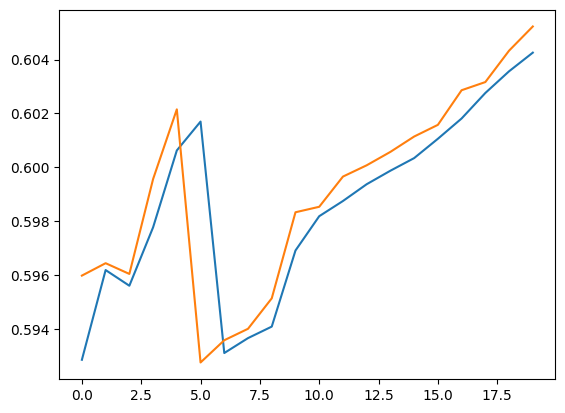

In [98]:
plt.plot(train_history.history["sparse_categorical_accuracy"])
plt.plot(train_history.history["val_sparse_categorical_accuracy"])
plt.show()

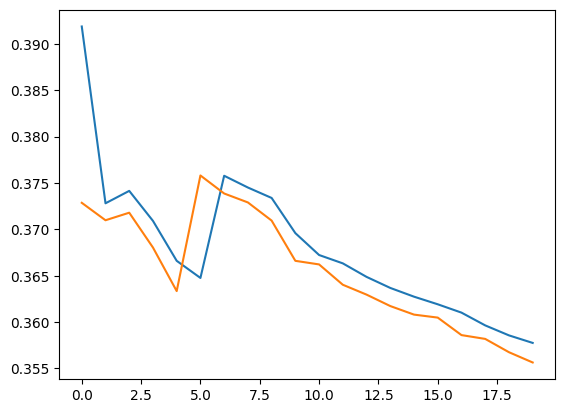

In [99]:
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])